# Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 05.10.2021

Мягкий дедлайн: 23:59MSK 19.10.2021

Жесткий дедлайн: 23:59MSK 23.10.2021

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{penalty} = M_{full} \cdot 0.85^{t/1440}$, где $M_{full}$ &mdash; полная оценка за работу без учета штрафа, а $t$ &mdash; время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше **8.5**, а если сдать перед самым жестким дедлайном, то ваш максимум &mdash; **5.22** балла.

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [118]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns

In [119]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2021-10-28 20:10:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  52.1MB/s    in 4.2s    

2021-10-28 20:10:46 (48.0 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [120]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34.56445,-5.07092,-47.75605,64.81513,-97.42948,-12.59418,55.23699,28.85657,54.53513,-31.97077,20.03279,-8.07892,-55.12617,26.58961,-10.27183,-30.64232,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.6

In [121]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [122]:
best_const = np.mean(df[0])
arr = np.tile(best_const, [len(df[0])])
mean_squared_error(y, arr) ** (1/2)

10.931035748764902

In [123]:
from sklearn.linear_model import Ridge

model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred) ** (1/2))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred) ** (1/2))

Test RMSE = 9.5102
Train RMSE = 9.5528


## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знайте, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [124]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [125]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [126]:
ss2 = StandardScaler()
y_train = ss2.fit_transform(y_train[:, None]).reshape(-1)
y_test = ss2.transform(y_test[:, None]).reshape(-1)

In [127]:
# Constants
SEED = 50 # random seed for reproducibility 
LR = 1e-3 # learning rate, controls the speed of the training 
WEIGHT_DECAY = 1e-3 # lambda for L2 reg. () 
NUM_EPOCHS = 10 # num training epochs (how many times each instance will be processed) 
GAMMA = 0.9995 # learning rate scheduler parameter 
BATCH_SIZE = 128 # training batch size 
EVAL_BATCH_SIZE = 300 # evaluation batch size. 
DEVICE = 'cpu' #'cuda' # device to make the calculations on

In [128]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = SEED)

In [129]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        super().__init__() # to initialize the parent class
        self.X = X
        self.y = y
        self.len = len(X)

    def __len__(self): # We use __func__ for implementing in-built python functions
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [130]:
train_set = MyDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_set = MyDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size = BATCH_SIZE,
    shuffle = True
)

val_set = MyDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size = BATCH_SIZE,
    shuffle = True
)

dls = {'train': train_loader, 'val': val_loader, 'test': test_loader}

class Model(nn.Module):
    def __init__(self, in_features = 90, out_features = 1):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_size = 100

        self.sequential = nn.Sequential( # NN architecure, where the modules modify the data sequentially
            nn.Linear(in_features, self.hidden_size), # Linear transformation
            nn.ReLU(), # Activation function 
            nn.Linear(self.hidden_size, self.hidden_size), # Linear transformation
            nn.ReLU(),
            nn.Linear(self.hidden_size, 50), # Linear transformation
            nn.ReLU(),
            nn.Linear(50, self.out_features) # Another Linear transformation

        )

    def forward(self, x): # In the forward function, you define how your model runs, from input to output 
        x = self.sequential(x)
        return x

model = Model()
model.to(DEVICE)

loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)
set_random_seed(SEED)

In [131]:
metrics_dict = {
    "Epoch": [],
    "Train RMSE": [],
    "Val RMSE": [],
  }

In [132]:
def rmse(preds, y_true):
        return ((preds - y_true) ** 2).mean() ** (1/2)

        
def eval_loop(model, X_val, X_test, y_val, y_test, model_is_nn=True, model_name="NN"):
        print(f"Model {model_name}")
        for name, x_eval, y_eval in zip(['val', 'test'], [X_val, X_test], [y_val, y_test]):
            if model_is_nn:
                with torch.no_grad():
                    preds = model(torch.Tensor(x_eval)).view(-1)
            else:
                model.fit(X_train, y_train)
                preds = model.predict(x_eval)
            # Don't forget to rescale the results back to measure loss in original space
            preds_rescheduled = preds * ss2.scale_ + ss2.mean_
            y_eval_rescheduled = y_eval * ss2.scale_ + ss2.mean_
            rmse_val = rmse(preds_rescheduled, y_eval_rescheduled)
            print(f'{name}: RMSE = {rmse_val:.2f}')
        return preds_rescheduled

In [133]:
def train(model, optimizer, criterion, train_loader, test_loader):
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    '''


    train_losses = []
    train_accuracies = []

  # Train loop
    for epoch in tqdm(range(NUM_EPOCHS)):
      metrics_dict["Epoch"].append(epoch)
      for stage in ['train', 'val']:
          with torch.set_grad_enabled(stage == 'train'): # Whether to start building a graph for a backward pass
              if stage == 'train':
                  model.train()
              else:
                  model.eval()

              loss_at_stage = 0 
              for batch in dls[stage]:
                  x_batch, y_batch = batch
                  x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)

                  y_pred = model(x_batch.float()).view(-1) 
                  loss = loss_fn(y_pred, y_batch.float())
                  if stage == "train":
                      loss.backward() # Calculate the gradients of all the parameters wrt loss
                      optimizer.step() # Update the parameters
                      criterion.step()
                      optimizer.zero_grad() # Zero the saved gradient
                  with torch.no_grad():
                      loss_at_stage += (torch.square((y_pred - y_batch) * ss2.scale_).sum()).item()
              rmse_at_stage = (loss_at_stage / len(dls[stage].dataset)) ** (1/2)
              metrics_dict[f"{stage.title()} RMSE"].append(rmse_at_stage)
    
      clear_output(wait=True)
      display(pd.DataFrame(metrics_dict))


      #raise NotImplementedError
      

def test(model, criterion, test_loader):
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''
    predicts = eval_loop(model, X_val, X_test, y_val, y_test, model_is_nn=True, model_name="NN")
    return predicts

In [134]:
train(model, optimizer, criterion, train_loader, test_loader)

,Epoch,Train RMSE,Val RMSE
0,0,8.905138,8.771154
1,1,8.613275,8.716580
2,2,8.549047,8.708929
3,3,8.531496,8.707850
4,4,8.527184,8.707441
5,5,8.526052,8.707373
6,6,8.525787,8.707365
7,7,8.525724,8.707363
8,8,8.525710,8.707363
9,9,8.525708,8.707363


In [135]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

Model NN
val: RMSE = 8.71
test: RMSE = 8.80


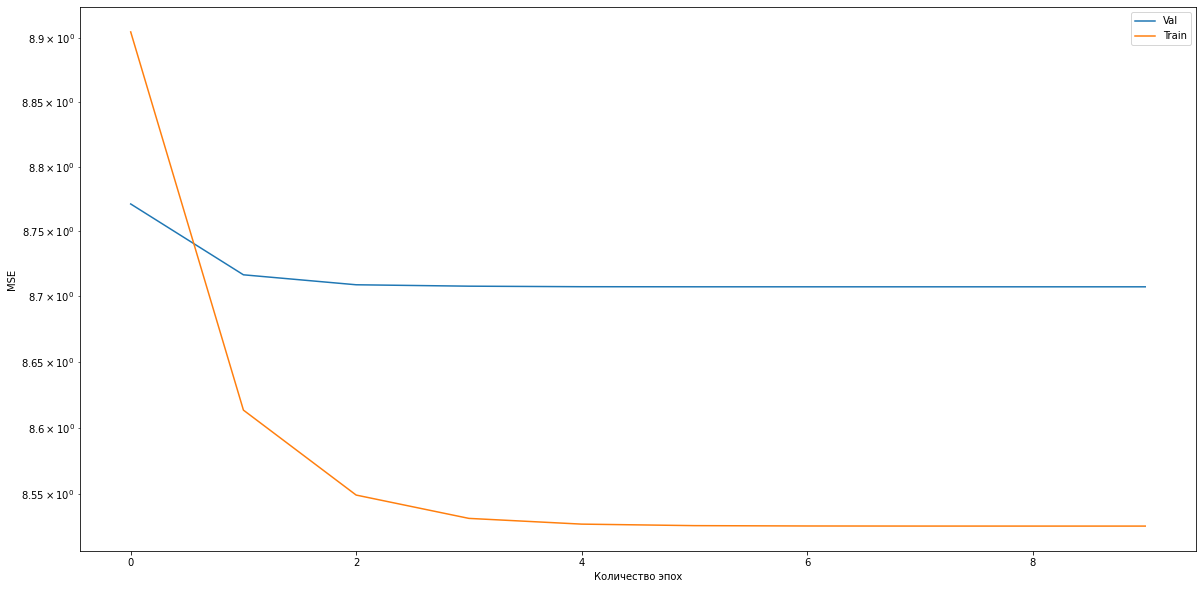

In [136]:
plt.figure(figsize=(20,10)) 
plt.plot(metrics_dict['Val RMSE'], label='Val') 
plt.plot(metrics_dict['Train RMSE'], label='Train') 
plt.ylabel('MSE') 
plt.xlabel('Количество эпох') 
plt.legend() 
plt.yscale('log') 
plt.show()

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

1) Изначально модель выглядила так, но я добавил еще слоев, без этого rmse была около 9.00


In [ ]:
class Model(nn.Module):
    def __init__(self, in_features = 36, out_features = 1):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_size = int(np.sqrt(in_features + out_features))

        self.sequential = nn.Sequential( # NN architecure, where the modules modify the data sequentially
            nn.Linear(in_features, self.hidden_size), # Linear transformation
            nn.ReLU(), # Activation function 
            nn.Linear(self.hidden_size, self.out_features) # Another Linear transformation
        )

    def forward(self, x): # In the forward function, you define how your model runs, from input to output 
        x = self.sequential(x)
        return x

2) Было изменено значение LR = 1e-3 # learning rate, controls the speed of the training



3) Было изменено значение WEIGHT_DECAY = 1e-3 # lambda for L2 reg. ()


Изначальные значения: WEIGHT_DECAY = 1e-2, LR = 3e-2 (ошибка стала 8.88)


4) Было изменено значение BATCH_SIZE = 128 # training batch size



Изначальное значение BATCH_SIZE = 32 (ошибка стала 8.80)

5) Так же было несколько вариантов значения NUM_EPOCHS, но за оптимальное я выбрал 10